### This file will focus on image processing and compression using SVD for grayscale and color images

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

### Basic Image Exploration

In [11]:
# load in a color image to work with
img = cv2.imread("Nature_by_Alyssa.JPG")

print("Image Shape: {}".format(img.shape))

Image Shape: (4000, 6000, 3)


Above we can see that there is a corresponding 4000x6000 array for Blue, Green, and Red color intensities.

We can use the item method to pull a given intensity as follows:

In [12]:
# get the green intensity for pixel corresponding to position 2000, 2000
img.item(2000, 2000, 1)

134

In [13]:
# how many pixels are in the image?
int(img.size/3) # divide by 3 as each pixel has B, G, R value

24000000

Because open cv specifies images as BGR and matplotlib specifies images as RGB, I will define a function to properly plot images inline using pyplot when inputting a BGR array

In [14]:
def plot_BGR(BGR_mat):
    imgB = BGR_mat[:, :, 0]
    imgG = BGR_mat[:, :, 1]
    imgR = BGR_mat[:, :, 2]
    
    newImg = np.dstack((imgR, imgG, imgB))
    return plt.imshow(newImg, vmin=0, vmax=255)


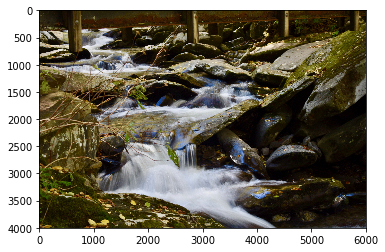

In [15]:
plot_BGR(img)

##### *Could we read in another image and blend them for fun?*

In [16]:
clt = cv2.imread("CLT.JPG")
clt.shape

(1512, 2016, 3)

We see that the image has a different size than our image of nature, so we need to make sure they are the same size. 

In [17]:
clt_resize = cv2.resize(clt, (6000, 4000))

(4000, 6000, 3)


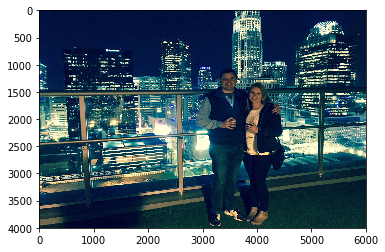

In [18]:
print(clt_resize.shape)
plot_BGR(clt_resize)

In [19]:
# now we can blend the images
combined = cv2.addWeighted(img, .6, clt_resize, .4, 0)

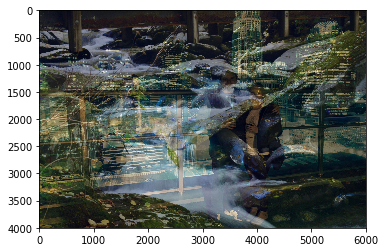

In [20]:
plot_BGR(combined)

Although these pictures are not the best to blend, it shows the idea. We can see the nature and the city within the same picture!

### Image Compression

#### grayscale

In [21]:
# read image in grayscale
imgGray = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY)

In [22]:
# get dimensions of array
imgGray.shape

(4000, 6000)

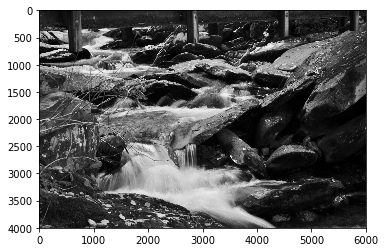

In [23]:
plt.imshow(imgGray, cmap='gray')

In [24]:
# next, we need to run svd on the grayscale image 
u, s, v = np.linalg.svd(imgGray)

We can create a line plot to see how many dimensions are needed to reconstruct the image

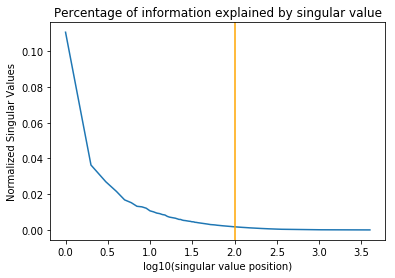

In [25]:
plt.plot([math.log(x+1, 10) for x in range(len(s))], s/sum(s))
plt.ylabel("Normalized Singular Values")
plt.xlabel("log10(singular value position)")
plt.title("Percentage of information explained by singular value")
plt.axvline(x = 2, color = "orange")
plt.show()

It looks like 10^2, or 100 out of the 4000 singular values would be more than enough to capture a good image. If this works, we'd only need about 2.5% of the data!

In [26]:
reconstructedGray = u[:, :100].dot((np.diag(s)[:100, :100].dot(v[:100, :])))


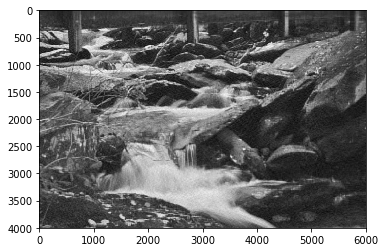

In [27]:
plt.imshow(reconstructedGray, cmap='gray')

It's a little blury, but overall very good for using only 100 out of 4000 singular values!

Now we can create a function, imgCompress, which will take in a grayscale image and compress it to a certain proportion between 0 and 1.

Because there will be a lot more deconstructed matrices (9 instead of 3), I'll only return the recontructed image with this function now. 

*Note the statement at the bottom of this script (future work). Creating a class would be more efficient to do this*

In [28]:
def imgCompress(img, compRatio, gray = True):
    # check inputs
    if str(type(img)) != "<class 'numpy.ndarray'>":
        raise TypeError("img must be a numpy array")
    
    if compRatio <= 0 or compRatio > 1:
        raise ValueError("compRatio must be greater than zero and no more than 1")
    
    # define dimensions
    svdDim = min(img.shape)
    redDim = int(svdDim*compRatio)

    # decompose img
    u, s, vT = np.linalg.svd(img, full_matrices=False)

    # return a list of tuple(compressed matrices) and reconstructed matrix
    return [(u[:, :redDim], np.diag(s)[:redDim, :redDim], vT[:redDim, :]), 
            u[:, :redDim].dot((np.diag(s)[:redDim, :redDim].dot(vT[:redDim, :])))]
    

In [29]:
reduced = imgCompress(imgGray, compRatio=.025)

In [30]:
# look at shape of outputs
print(reduced[0][0].shape)
print(reduced[0][1].shape)
print(reduced[0][2].shape)
print("\n")

# What are the dimensions of the reconstructed data frame? Hopefully 4000x6000!
print(reduced[1].shape)

(4000, 100)
(100, 100)
(100, 6000)


(4000, 6000)


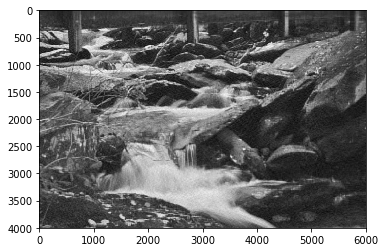

In [31]:
plt.imshow(reduced[1], cmap = "gray")

Great! It looks like the function is working well. Can we generalize this function to take in a color image?

In [32]:
def imgCompress(img, compRatio, gray = True):
    # check inputs
    if str(type(img)) != "<class 'numpy.ndarray'>":
        raise TypeError("img must be a numpy array")
    
    if compRatio <= 0 or compRatio > 1:
        raise ValueError("compRatio must be greater than zero and no more than 1")
        
    if gray:
    
        # define dimensions
        svdDim = min(img.shape)
        redDim = int(svdDim*compRatio)

        # decompose img
        u, s, vT = np.linalg.svd(img, full_matrices=False)

        # return a list of tuple(compressed matrices) and reconstructed matrix
        return [(u[:, :redDim], np.diag(s)[:redDim, :redDim], vT[:redDim, :]), 
                u[:, :redDim].dot((np.diag(s)[:redDim, :redDim].dot(vT[:redDim, :])))]
    
    else:
        
        if img.shape[2] > img.shape[1] or img.shape[2] > img.shape[0]:
            raise TypeError("Please Make sure that the BGR arrays constitute \
                            the 3rd dimension of the 3-d array")
        
        # define dimensions
        svdDim = min(img.shape[:2])
        redDim = int(svdDim*compRatio)
        
        # initialize a list to hold the B, G, R arrays respectively
        bgrArrays = []
        for i in range(img.shape[2]):
            
            # get single color layer
            layer = img[:, :, i]
            
            # perform decomposition
            u, s, vT = np.linalg.svd(layer, full_matrices=False)
            
            # append the new array to bgrArrays
            newArray = u[:, :redDim].dot((np.diag(s)[:redDim, :redDim].dot(vT[:redDim, :])))
            
            # adjust values under 0 or over 255 to limits
            newArray[newArray < 0] = 0
            newArray[newArray > 255] = 255
            
            bgrArrays.append(newArray.astype(np.uint8))
            
            print(str(i+1), "of", str(3), "arrays decomposed")
        
        return(np.dstack(bgrArrays))    

Now let's try to compress (30% of original size) and reconstruct the Charlotte image with color!

In [33]:
reducedColor = imgCompress(img, compRatio=.3, gray = False)

1 of 3 arrays decomposed
2 of 3 arrays decomposed
3 of 3 arrays decomposed


In [34]:
# look at the shape of the reconstructed photo
print(reducedColor.shape)

(4000, 6000, 3)


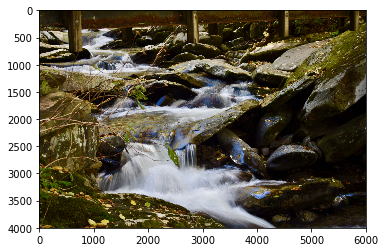

In [35]:
# plot the new photo
plot_BGR(reducedColor)

Awesome!It looks like we were able to reconstruct the color image very well with only about 30% of the original data! 

Lastly, let's see if we can reproduce the blended image with only 30% of the original data. 

1 of 3 arrays decomposed
2 of 3 arrays decomposed
3 of 3 arrays decomposed


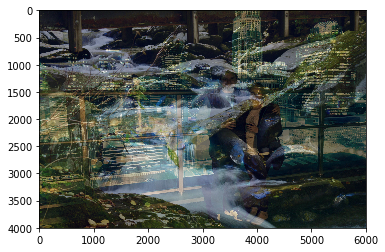

In [36]:
# compress and reconstruct the blended image
combinedComp = imgCompress(combined, compRatio=.3, gray=False)

# plot the reconstructed image
plot_BGR(combinedComp)

The function appears to work very well! It is amazing how we can recreate images well with so little of the original data. This displays the utility of SVD.

### Future Work

It'd be far more efficient to create a class for image compression where we only have to decompose the image once. Once we have u, s, and v transpose, we can then define a method to return the image array with the proper amount of compression that we desire.